#  **1. Installation of required libraries** #

In [3]:
!pip install numpy
!pip install pandas 
!pip install matplotlib
!pip install geopandas

     ---------------------------------------- 0.0/61.0 kB ? eta -:--:--
     -------------------- ------------------- 30.7/61.0 kB 1.3 MB/s eta 0:00:01
     ---------------------------------------- 61.0/61.0 kB 1.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/15.8 MB ? eta -:--:--
   - -------------------------------------- 0.5/15.8 MB 16.8 MB/s eta 0:00:01
   --- ------------------------------------ 1.5/15.8 MB 24.3 MB/s eta 0:00:01
   ------ --------------------------------- 2.7/15.8 MB 24.7 MB/s eta 0:00:01
   --------- ------------------------------ 3.8/15.8 MB 27.0 MB/s eta 0:00:01
   ------------- -------------------------- 5.2/15.8 MB 30.1 MB/s eta 0:00:01
   --------------- ------------------------ 6.0/15.8 MB 29.4 MB/s eta 0:00:01
   ---------------- ----------------------- 6.4/15.8 MB 23.9 MB/s eta 0:00:01
   ------------------- -------------------- 7.5/15.8 MB 25.3 MB/s eta 0:00:01
   ---------------------- ----------------- 8.9/15.8 MB 25.7 MB/s eta 0:00

In [3]:
# Importing the required libraries to visualise correctly the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from collections import Counter
import ast

# **2. Set up the paths to the datasets** #

In [4]:
# Path to the dataset file
dataset_path = "content/Datasets_v2.csv"
dataset_path2 = "content/Datasets_v3.csv"

In [5]:
# Load dataset from file
df = pd.read_csv(dataset_path)
df2 = pd.read_csv(dataset_path2)

# Print column names and first few rows
print("Column names for Datasets_v2:")
print(df.columns)

print("\nColumn names for Datasets_v3:")
print(df.columns)

Column names for Datasets_v2:
Index(['Name', 'Use', 'Localisation', 'CoverYear', 'NbClass', 'ClassName',
       'NbImage', 'PixelSize', 'Spatial Resolution (m)', 'Nb Bands',
       'Spectral Resolution', 'Reference'],
      dtype='object')

Column names for Datasets_v3:
Index(['Name', 'Use', 'Localisation', 'CoverYear', 'NbClass', 'ClassName',
       'NbImage', 'PixelSize', 'Spatial Resolution (m)', 'Nb Bands',
       'Spectral Resolution', 'Reference'],
      dtype='object')


# **3. Function to convert string (of list) to list** #

In [6]:
# As the data are encoded in this form: "[x,y,z]", we need to extract the list from the string
def convert_string_to_list(string):
    try:
        return ast.literal_eval(string)
    except ValueError:
        return []  # Returns an empty list if the string cannot be evaluated

# **4. Data Visualisation (Dataset_v2)** #

### **4.1 Localisation Visualisation** ###

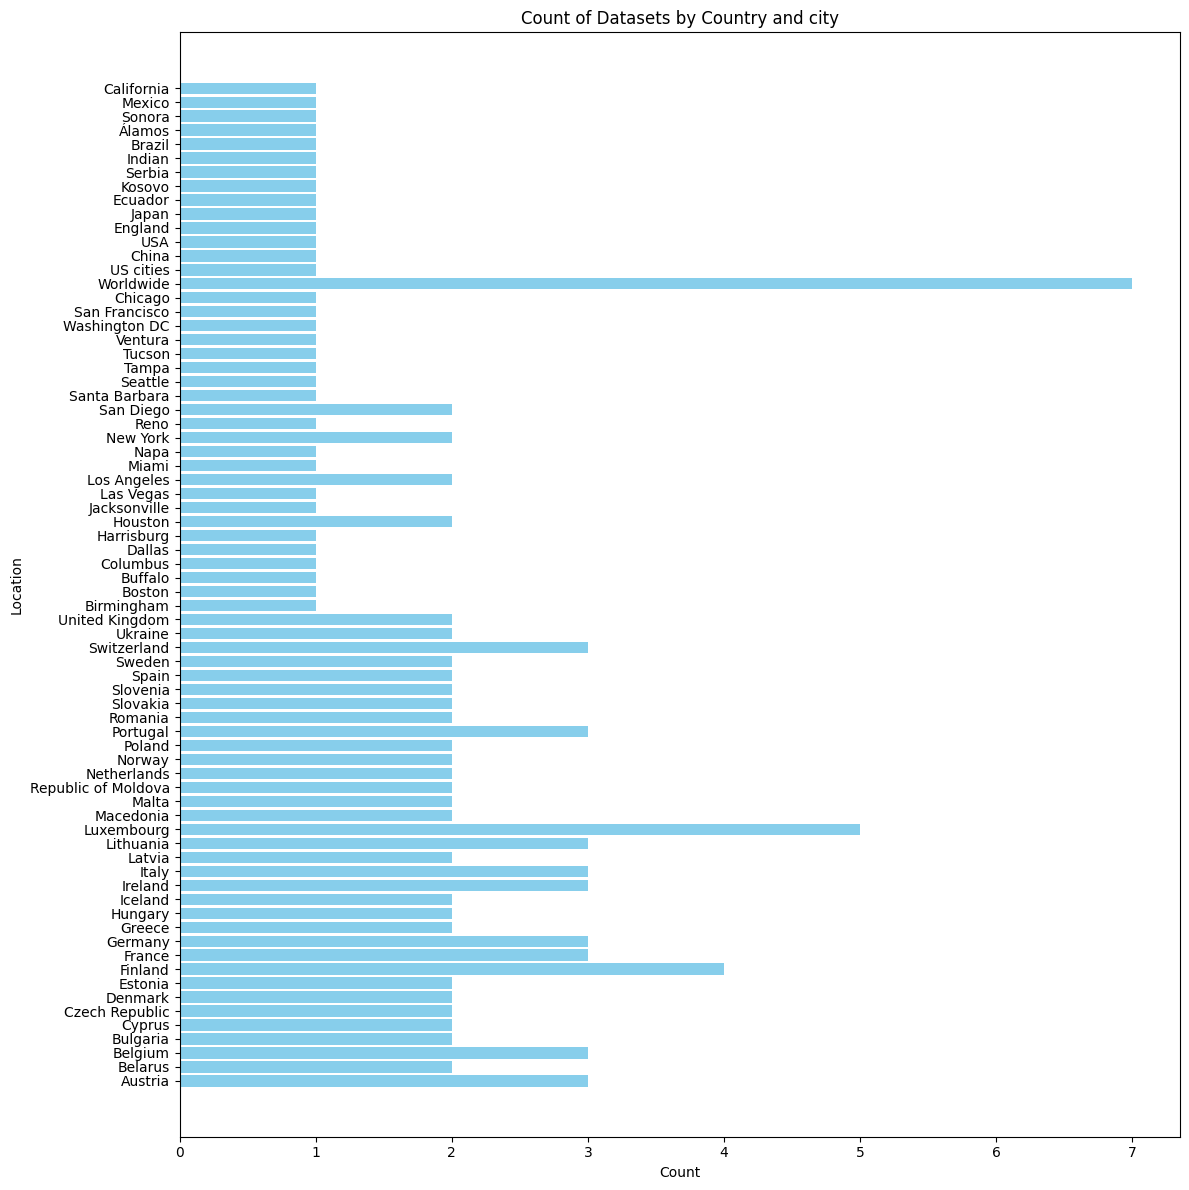

In [7]:
# Apply the conversion function to each row in the 'Localisation' column
localisation_df = pd.DataFrame(df['Localisation'].apply(convert_string_to_list))

# Flatten the list of lists to count each country's occurrences
all_countries = [country for sublist in localisation_df['Localisation'] for country in sublist]
country_counts = Counter(all_countries)

countries = list(country_counts.keys())  # Unique country names
counts = list(country_counts.values())  # Corresponding counts


# Bar Chart for Countries and cities Counts
plt.figure(figsize=(12, 12))
plt.barh(countries, counts, color='skyblue')
plt.xlabel('Count')
plt.ylabel('Location')
plt.title('Count of Datasets by Country and city')
plt.tight_layout()
plt.show()

C:\Users\Elliot\AppData\Local\Temp\ipykernel_22604\3674329554.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


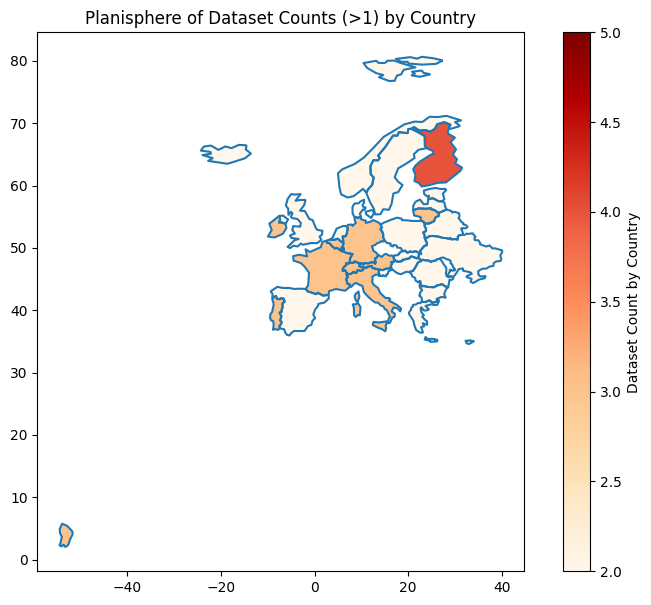

In [8]:
# Convert country_counts to a DataFrame for easier merging
country_counts_df = pd.DataFrame(list(country_counts.items()), columns=['country', 'count'])

# Load the world map from GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


# Merge the counts with the Europe GeoDataFrame
world_counts = world.merge(country_counts_df, left_on='name', right_on='country', how='left')

# Filter to show only countries with more than 1 dataset
world_counts_filtered = world_counts[(world_counts['count'] > 1) & (world_counts['name'] != '')]


# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
world_counts_filtered.boundary.plot(ax=ax)
world_counts_filtered.plot(column='count', ax=ax, legend=True,
                   legend_kwds={'label': "Dataset Count by Country"},
                   cmap='OrRd', missing_kwds={'color': 'lightgrey'})
plt.title('Planisphere of Dataset Counts (>1) by Country')
plt.show()

### **4.2 Pixel Size Visualisation** ###

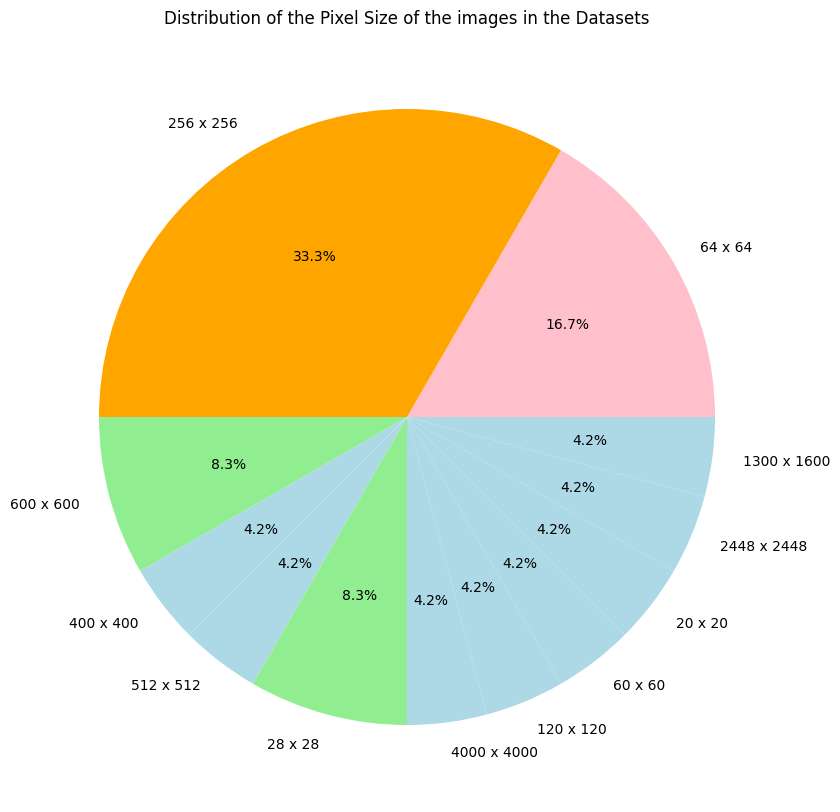

In [9]:
# Apply the conversion function to each row in the 'PixelSize' column
pixel_df = pd.DataFrame(df['PixelSize'].apply(lambda x: ast.literal_eval(x)))

# Count the occurrences of each pixel size
all_pixel_sizes = [size for sublist in pixel_df['PixelSize'] for size in sublist]
pixel_size_counts = Counter(all_pixel_sizes)

sizes = list(pixel_size_counts.values()) # Unique pixel size
labels = list(pixel_size_counts.keys())  # Corresponding counts

# Extract unique count values and sort them
unique_counts = sorted(set(pixel_size_counts.values()))
# Map each unique count value to a color
colors = ['lightblue', 'lightgreen', 'pink', 'orange']
count_to_color = {count: color for count, color in zip(unique_counts, colors)}
# Now, map each pixel size to a color based on its count value
slice_colors = [count_to_color[count] for count in sizes]

# Plot the Pie Chart
plt.figure(figsize=(10, 10))
plt.pie(sizes, labels=labels, autopct='%1.1f%%',colors=slice_colors)
plt.title('Distribution of the Pixel Size of the images in the Datasets')
plt.show()

### **4.3 Class Visualisation (forest-related)** ###

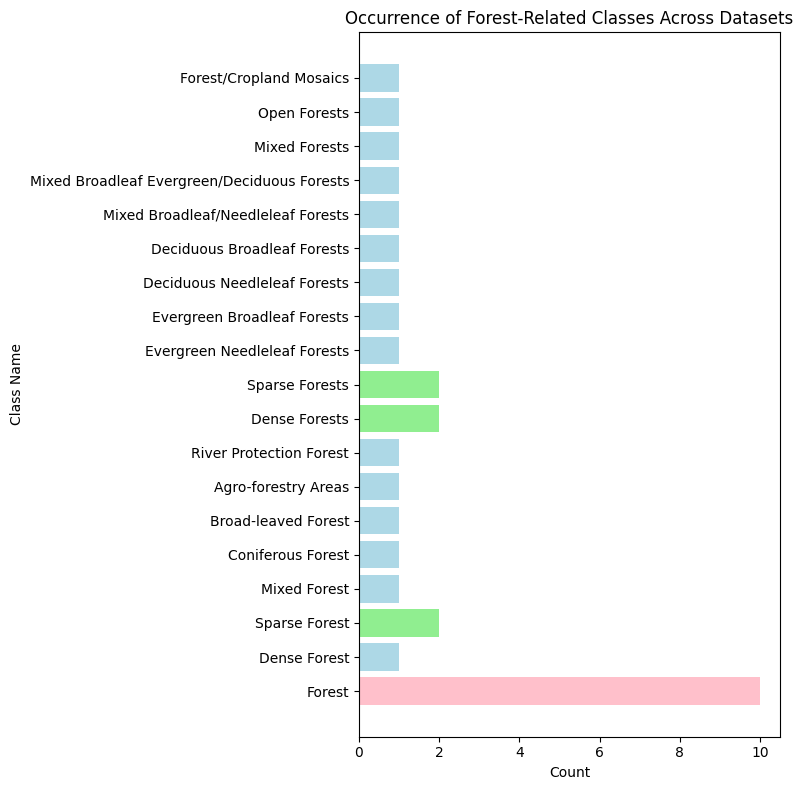

In [10]:
# Apply the conversion function to each row in the 'ClassName' column
class_df = pd.DataFrame(df['ClassName'].apply(lambda x: ast.literal_eval(x)))

# Adjust the find_keyword function to filter only for 'forest'
def find_keyword(cls, keyword):
    return keyword if keyword in cls.lower() else None

# Filtering only classes containing 'forest'
forest_classes = []
for sublist in class_df['ClassName']:
    for cls in sublist:
        if find_keyword(cls, 'forest'):
            forest_classes.append(cls)

# Count occurrences of forest-related classes
forest_counts = Counter(forest_classes)

forest_class_names = list(forest_counts.keys()) # Unique class name
forest_class_counts = list(forest_counts.values()) # Corresponding counts

# Extract unique count values and sort them
unique_counts = sorted(set(forest_class_counts))
# Map each unique count value to a color
colors = colors = ['lightblue', 'lightgreen', 'pink', 'orange']
count_to_color = {count: color for count, color in zip(unique_counts, colors)}
# Map each class's count to a color
bar_colors = [count_to_color[count] for count in forest_class_counts]

# Plotting 
plt.figure(figsize=(8, 8))
plt.barh(forest_class_names, forest_class_counts, color=bar_colors)
plt.xlabel('Count')
plt.ylabel('Class Name')
plt.title('Occurrence of Forest-Related Classes Across Datasets')
plt.tight_layout()
plt.show()


In [11]:
# Load dataset from file (we need Name and ClassName column)
class_df = pd.read_csv(dataset_path)

# Convert 'ClassName' column from string representation of lists to actual lists
class_df['ClassName'] = class_df['ClassName'].apply(lambda x: ast.literal_eval(x))

# Initialize a dictionary to store the count of 'forest' in labels for each dataset
forest_label_counts = {}

for index, row in df.iterrows():
    # Count occurrences of 'forest' in each dataset's labels
    forest_count = sum('forest' in label.lower() for label in row['ClassName'])
    if forest_count > 0:
        forest_label_counts[row['Name']] = forest_count

# Print the datasets that have the word 'forest' in their labels
for dataset, count in forest_label_counts.items():
    print(f"{dataset}: {count}")

# Identify the dataset with the most 'forest' labels
if forest_label_counts:
    max_forest_dataset = max(forest_label_counts, key=forest_label_counts.get)
    print(f"\nDataset with the most 'forest' labels: {max_forest_dataset} ({forest_label_counts[max_forest_dataset]} labels)")
else:
    print("No datasets with 'forest' in their labels were found.")

No datasets with 'forest' in their labels were found.


### **4.4 Spatial Resolution** ###

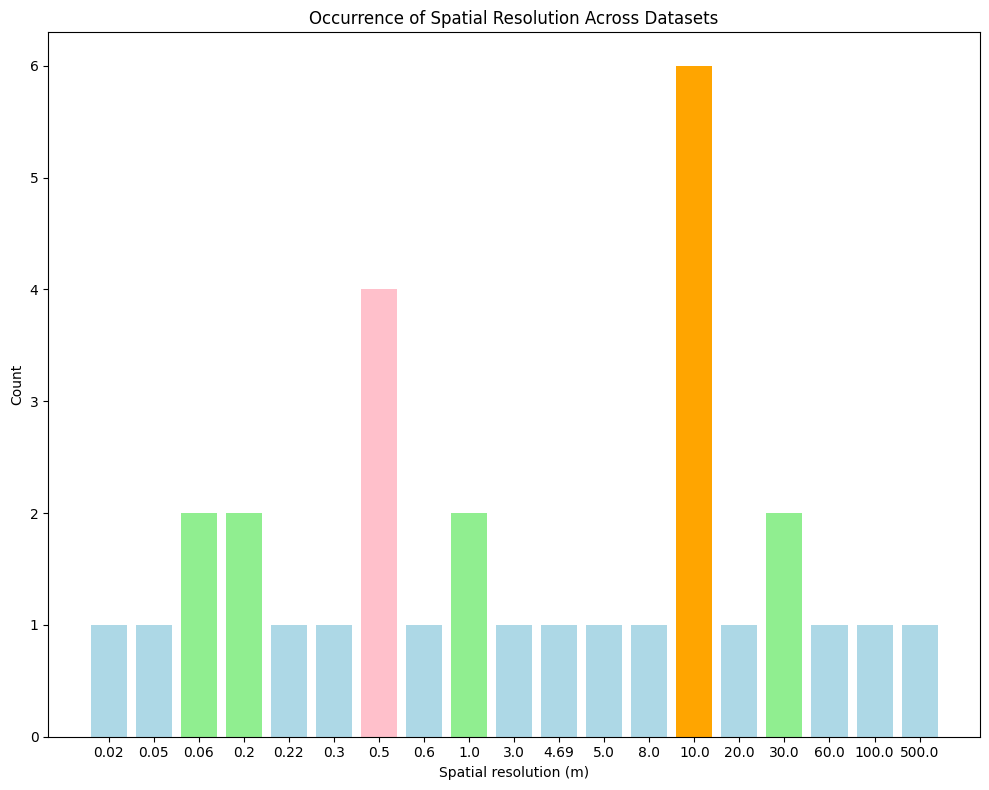

In [12]:
# Convert string representations of lists to actual lists and handle the spatial resolution values correctly
SpR_df = pd.DataFrame(df['Spatial Resolution (m)'].apply(lambda x: ast.literal_eval(x)))

# Normalize the spatial resolution values (replace commas and convert to float)
def normalize_and_convert_to_float(values):
    return [float(value.replace(',', '.')) for value in values]

# Convert list of string float (['1,5','2']) to actual float and handle the spatial resolution values correctly
all_SpR = [size for sublist in SpR_df['Spatial Resolution (m)'].apply(normalize_and_convert_to_float) for size in sublist]
SpR_counts = Counter(all_SpR)

# Convert the counts to a DataFrame
SpR_df = pd.DataFrame(list(SpR_counts.items()), columns=['Spatial Resolution (m)', 'Count'])

# Now sort the DataFrame by 'Spatial Resolution (m)' as floats
SpR_df_sorted = SpR_df.sort_values(by='Spatial Resolution (m)', ascending=True)

# Extract the sorted values for plotting
sizes_sorted = SpR_df_sorted['Count'].values
labels_sorted = SpR_df_sorted['Spatial Resolution (m)'].astype(str).values  # Convert to string for plotting

unique_counts = sorted(list(SpR_df_sorted['Count'].unique())) # Corresponding counts

# Create a color mapping for each unique count value
colors = ['lightblue', 'lightgreen', 'pink', 'orange']
color_mapping = {count: colors[i % len(colors)] for i, count in enumerate(unique_counts)}
# Apply color mapping to get a list of colors for each row in the DataFrame
colors_for_plotting = [color_mapping[count] for count in SpR_df_sorted['Count']]

# Plotting with color mapping
plt.figure(figsize=(10, 8))
plt.bar(labels_sorted, sizes_sorted, color=colors_for_plotting)
plt.ylabel('Count')
plt.xlabel('Spatial resolution (m)')
plt.title('Occurrence of Spatial Resolution Across Datasets')
plt.tight_layout()
plt.show()

### **4.5 Spectral Resolution** ###

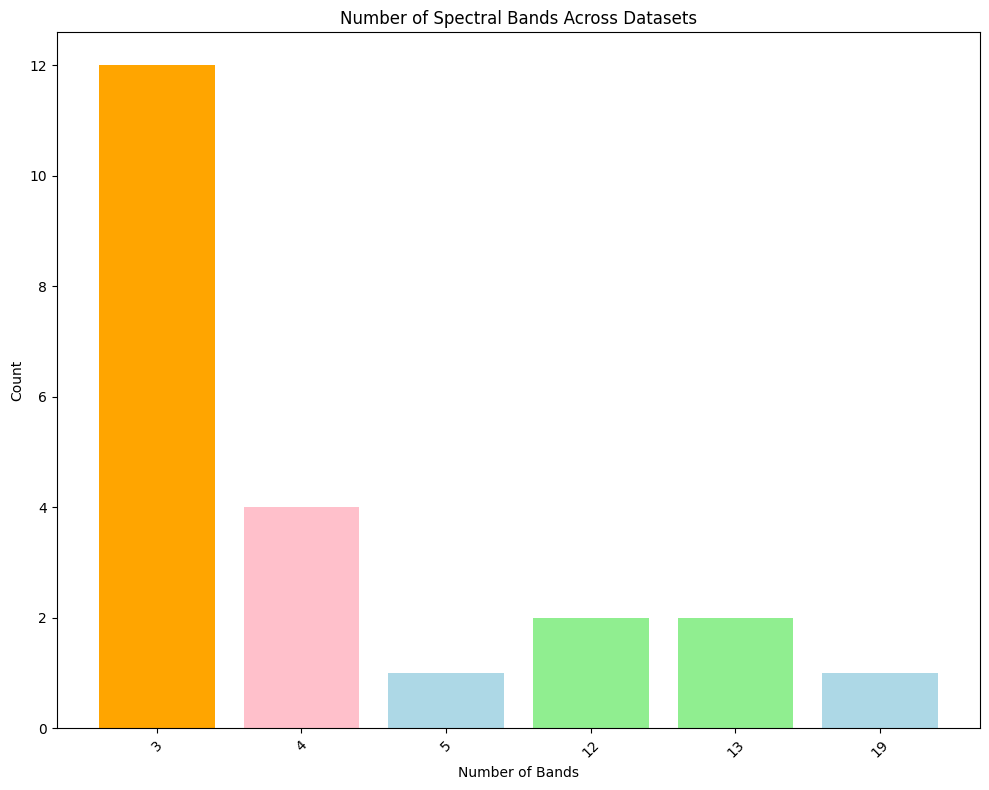

In [13]:
# Count the occurrences of each number of bands
Spectral_df = pd.DataFrame(df['Nb Bands'])

# Retrieve all the number of bands for each dataset & count them
all_Bands = [num for num in Spectral_df['Nb Bands']]
Band_counts = Counter(all_Bands)

# Convert the counts to a DataFrame for easier sorting and manipulation
Spectral_df = pd.DataFrame(list(Band_counts.items()), columns=['Nb Bands', 'Count'])

# Filter for datasets to remove the non data (0)
Spectral_df_filtered = Spectral_df[Spectral_df['Nb Bands'] >0]

# Sort the DataFrame by 'Nb Bands' in ascending order
Spectral_df_sorted = Spectral_df_filtered.sort_values(by='Nb Bands', ascending=True)

# Extract the sorted values for plotting
sizes_sorted = Spectral_df_sorted['Count'].values
labels_sorted = Spectral_df_sorted['Nb Bands'].astype(str).values  # Convert to string for plotting

unique_counts = sorted(list(Spectral_df_sorted['Count'].unique())) # Corresponding counts

# Create a color mapping for each unique count value
colors = ['lightblue', 'lightgreen', 'pink', 'orange']
# Cycle through the color list if there are more unique counts than colors
color_mapping = {count: colors[i % len(colors)] for i, count in enumerate(unique_counts)}
# Apply color mapping to get a list of colors for each row in the DataFrame
colors_for_plotting = [color_mapping[count] for count in Spectral_df_sorted['Count']]

# Plotting with color mapping
plt.figure(figsize=(10, 8))
plt.bar(labels_sorted, sizes_sorted, color=colors_for_plotting)
plt.ylabel('Count')
plt.xlabel('Number of Bands')
plt.xticks(rotation=45)  # Rotate labels if they overlap
plt.title('Number of Spectral Bands Across Datasets')
plt.tight_layout()
plt.show()

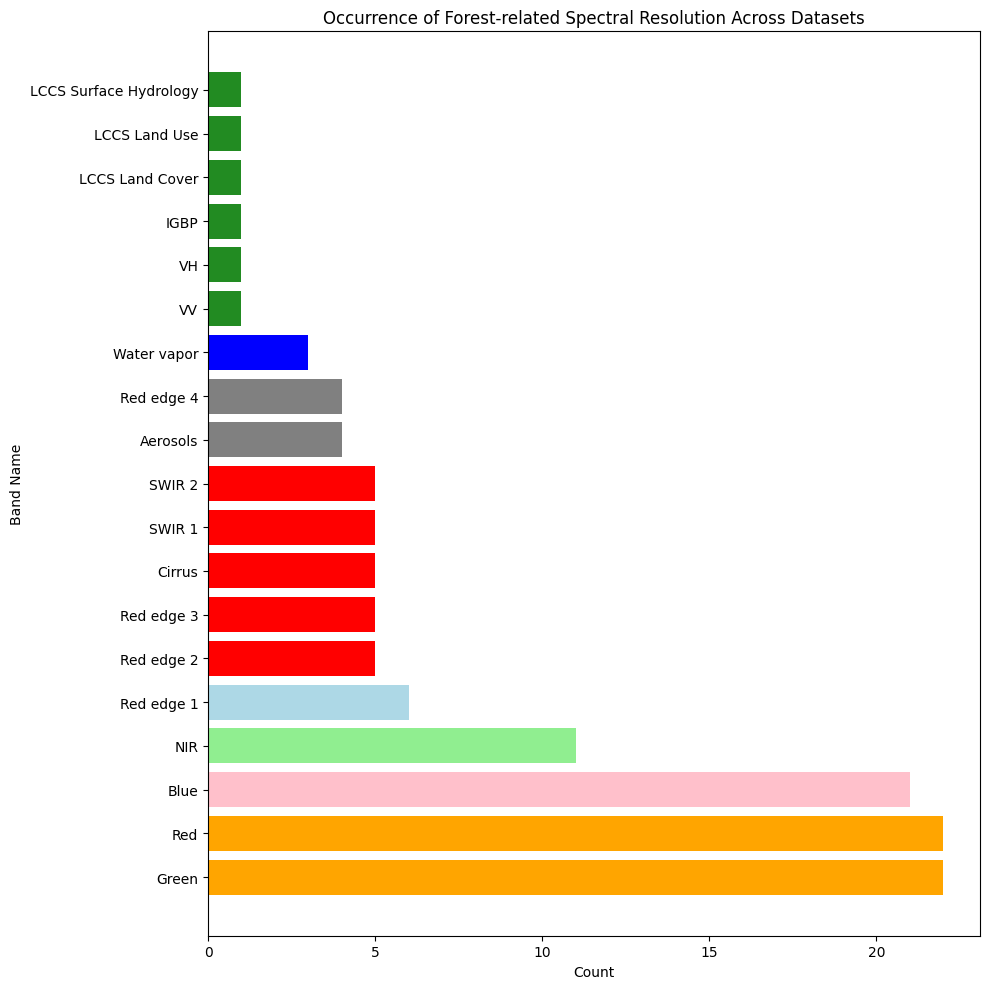

In [19]:
# Convert 'Spectral Resolution' from string-list to actual lists
Bands_name_df = pd.DataFrame(df['Spectral Resolution'].apply(lambda x: ast.literal_eval(x)))

# Flatten the list of lists to get all band names
bands_classes = [item for sublist in Bands_name_df['Spectral Resolution'] for item in sublist]

# Count occurrences of bands name
bands_counts = Counter(bands_classes)


band_class_names = list(bands_counts.keys()) # Unique class name
band_class_counts = list(bands_counts.values()) # Corresponding counts

# Sort the data by count for better visualization
sorted_indices = sorted(range(len(band_class_counts)), key=lambda k: band_class_counts[k], reverse=True)
sorted_band_class_names = [band_class_names[i] for i in sorted_indices]
sorted_band_class_counts = [band_class_counts[i] for i in sorted_indices]


# Extract unique count values and sort them
unique_counts = sorted(set(band_class_counts))
# Create a color mapping for each unique count value
colors = ['forestgreen', 'blue', 'gray', 'red', 'lightblue', 'lightgreen', 'pink', 'orange']
count_to_color = {count: colors[i] for i, count in enumerate(unique_counts)}
# Map each class's count to a color
bar_colors = [count_to_color[count] for count in sorted_band_class_counts]

# Plotting with count-based colors
plt.figure(figsize=(10, 10))
plt.barh(sorted_band_class_names, sorted_band_class_counts,color = bar_colors)
plt.xlabel('Count')
plt.ylabel('Band Name')
plt.title('Occurrence of Forest-related Spectral Resolution Across Datasets')
plt.tight_layout()
plt.show()
